<a href="https://colab.research.google.com/github/maggiemcc02/Summer2023_Codes/blob/main/Madden_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I am hoping to solve the problem in section 3.3 of *Generating Layer-Adapted Meshes Using Mesh PDE's*:

$$ -\epsilon^2 \nabla^2u + u = x  \text{ for } (x,y)\in Ω $$

Where $\Omega$ is the unit square.

Not only do I hope to solve this problem, I hope to solve it on adapted meshes. To do so, I shall use the adaptive mesh scheme presented in the paper. Such scheme involves iterating through solves of $ \nabla \cdot (M(s) \nabla x(\xi, \eta)) = (0, 0)^T $ where $s$ is the current solution approximation interpolated onto the current mesh $x(\xi, \eta).$ The repeated solves of this MMPDE are linear solves because $s$ is always one mesh behind ($s$ is interpolated onto mesh $k$ when we are trying to find mesh $k+1$).

The specific boundary conditions and choice of $M$ are explored in this notebook. I have many issues choosing these values.

All of this work will be done with FireDrake which is installed in the first cell of this notebook. The documentation can be found [here](https://www.firedrakeproject.org/documentation.html).





# New Section

# Installing FireDrake and Importing Needed Tools

In [ ]:
try:
  from firedrake import *
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
  from firedrake import *

In [ ]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

# Mesh Update Function

In [ ]:


def Mesh_Iter(u_sol, initial_mesh, V, iter):



  # set the initial_mesh

  mesh = initial_mesh

  #xi, eta = SpatialCoordinate(mesh)
  # u_sol = Function(V).interpolate(xi**2 + eta**2) # MY TEST u_sol


  for i in range(iter):

    # indicate a new mesh solve


    print()
    print()
    print('~' * 35)
    print('MESH SOLVE ', i+1)
    print('~'*35)
    print()
    print()


    # the plotting test


    # W1 = FunctionSpace(mesh, "CG", 1)
    # W2 = FunctionSpace(mesh, "DG", 0)


    # xi, eta = SpatialCoordinate(mesh)

    # f1 = Function(W1).interpolate(xi**2 + eta**2)
    # f2 = Function(W2).interpolate(xi**2 + eta**2)

    # fig, axes = plt.subplots()
    # colors = tripcolor(f1, axes = axes)
    # plt.title('f1')
    # fig.colorbar(colors)
    # plt.show()
    # print()
    # print()

    # fig, axes = plt.subplots()
    # colors = tripcolor(f2, axes = axes)
    # plt.title('f2')
    # fig.colorbar(colors)
    # plt.show()
    # print()
    # print()



    # Compute the mesh density function

    grad_u = grad(u_sol)
    u_x = grad_u[0]
    u_y = grad_u[1]
    M = sqrt(1 + u_x**2 + u_y**2)

    V_M = FunctionSpace(mesh, "CG", 1)
    M_proj = interpolate(M, V_M)
    M_values = M_proj.dat.data[:]


    # gradx_proj = interpolate(u_x, V_M)
    # grady_proj = interpolate(u_y, V_M)s
    # ux_val = gradx_proj.dat.data[:]
    # uy_val = grady_proj.dat.data[:]


    # Print the values of M
    print("Values of M at vertices:")
    print(M_values)
    print()
    print()

    # Check that M is NOT coordinateless:

    # if M_proj.ufl_domain() is None:
    #   print("M_proj is coordinateless.")
    # else:
    #   print("M_proj is associated with a mesh.")


    fig, axes = plt.subplots()
    colors = tripcolor(M_proj, axes = axes)
    plt.title('M Approximation')
    fig.colorbar(colors)
    plt.show()
    print()
    print()




    # solve the mesh problem  - x

    xi, eta = SpatialCoordinate(mesh)


    # set the test and and trial functions

    x  = TrialFunction(V)
    v = TestFunction(V)

    # define the  problem

    a =  ( M *inner( grad(x), grad(v) ) )* dx

    L = ( Constant(0) * v  ) * dx

    # define the BC's
    # conditions for a uniform mesh


    bc1 =  DirichletBC(V, Constant(0), 1) # left
    bc2 = DirichletBC(V, Constant(1), 2) # right
    bc3 = DirichletBC(V, xi, 3) # bottom
    #bc4 = DirichletBC(V, xi, 4)


    bcs = [  bc1, bc2, bc3 ]

    # solve

    x_sol = Function(V)

    solve(a == L, x_sol, bcs = bcs)




    # solve the mesh problem - y






    # set the test and and trial functions

    y  = TrialFunction(V)
    v = TestFunction(V)


    # define the nonlinear problem

    a = (M *inner( grad(y), grad(v) ) )* dx

    L = ( Constant(0) * v  ) * dx

    # define the BC's
    # conditions for a uniform mesh

    #bc1 =  DirichletBC(V, eta, 1) # left
    #bc2 = DirichletBC(V, eta, 2) # right
    bc3 = DirichletBC(V, Constant(0), 3) # bottom
    bc4 = DirichletBC(V, Constant(1), 4) # top

    bcs = [ bc3, bc4 ]

    # solve

    y_sol = Function(V)

    solve(a == L, y_sol, bcs = bcs)

    # The parameters I can use in solve() to print out solver info:
    #solver_parameters={'ksp_converged_reason': None,
                   #'ksp_monitor_true_residual': None,
                   #'ksp_view': None}



    # Create and plot the new mesh

    N = np.shape(x_sol.dat.data)[0]
    mesh_values = np.zeros([N,2])
    mesh_values[:,0] = x_sol.dat.data
    mesh_values[:,1] = y_sol.dat.data
    mesh.coordinates.dat.data[:] = mesh_values
    fig, axes = plt.subplots()
    triplot(mesh, axes=axes)
    plt.title("Adapted Mesh for the Current Solution")
    plt.show()

    print()
    print()



    # My jacobian test

    W = VectorFunctionSpace(mesh, "CG", 1, dim = 2)

    xw = Function(W)


    xw = Function(W).interpolate(as_vector([x_sol, y_sol]))


    grad_w = grad(xw)


    det_w = det(grad_w)


    # the values

    det_vals = assemble(det_w*dx)

    print("The Determinant of the gradient of the new mesh is : ", det_vals)
    print()



  return mesh



# One MP Iteration

## First Physical Solve

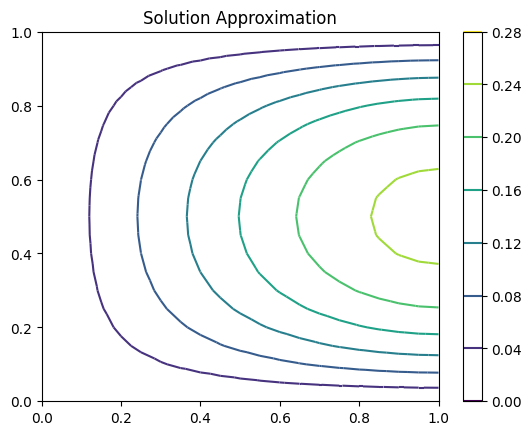

In [ ]:
# SOLVE THE PHYSICAL PROBLEM


mesh0 = UnitSquareMesh(20, 20)
epsilon = Constant(0.5)


# set the function space - a vector function space

V = FunctionSpace(mesh0, "CG", 1)

# Access the Mesh Coordinates

xi, eta = SpatialCoordinate(mesh0) # mesh is \xi and \eta

# set the test and and trial functions

u  = TrialFunction(V)
v = TestFunction(V)

# set f

f = Function(V)


f.interpolate( xi )

# define the problem

a = (  (epsilon**2) * inner( grad(u), grad(v) ) + inner(u, v) ) * dx
L = ( inner( f, v ) ) * dx


# define the BC's

bc1 =  DirichletBC(V, Constant(0) , 1)
bc3 = DirichletBC(V, Constant(0) , 3)
bc4 = DirichletBC(V, Constant(0) , 4)


bcs = [ bc1, bc3, bc4]

# solve the problem

u_sol = Function(V)

solve(a == L, u_sol, bcs = bcs)

# Colour Plot

fig, axes = plt.subplots()
colors = tricontour(u_sol, axes = axes)
plt.title('Solution Approximation')
fig.colorbar(colors)
plt.show()
print()
print()





## Mesh Iteration



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.         1.00235199 1.00235199 1.00409674 1.0093554  1.00815371
 1.00931486 1.00939896 1.0208696  1.01584474 1.01791579 1.01315756
 1.01668608 1.03667442 1.02424012 1.02975493 1.01937122 1.01927031
 1.02475987 1.05647865 1.03246159 1.04463725 1.02794519 1.02355936
 1.02641413 1.03273024 1.07993116 1.03987266 1.06232162 1.03874938
 1.02949038 1.02917705 1.03366249 1.03995105 1.10663196 1.04602334
 1.08252507 1.05161941 1.03697584 1.03300568 1.03523963 1.04033907
 1.04596488 1.13614141 1.05060622 1.10492628 1.06635735 1.04590313
 1.03783961 1.03743076 1.04102202 1.04596298 1.05045902 1.16798636
 1.05342395 1.12916746 1.08273199 1.0561339  1.04360025 1.04019238
 1.04197607 1.04600503 1.05020451 1.05323269 1.20166252 1.05436703
 1.15485425 1.10047831 1.06750292 1.05018973 1.04346766 1.04316793
 1.04607116 1.04983105 1.05285193 1.05417474 1.23663248 1.05340095
 1.18155296 1.

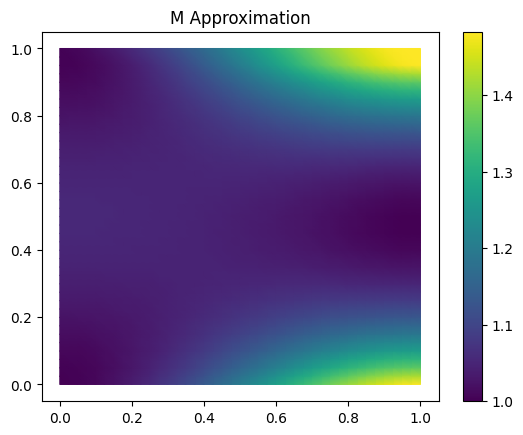

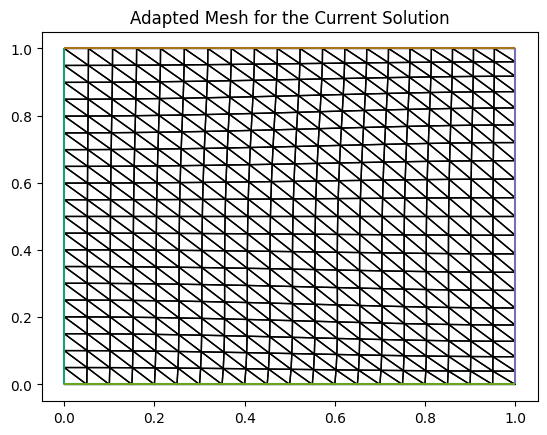



The Determinant of the gradient of the new mesh is :  0.9999999999999987



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.         1.00230691 1.00231771 1.00402273 1.00929343 1.00790808
 1.00917663 1.00917103 1.02101134 1.01527786 1.01777884 1.01295531
 1.016181   1.03759786 1.02331431 1.02984522 1.01923381 1.01888629
 1.02392213 1.05918995 1.03119953 1.04538684 1.02796449 1.02335253
 1.02575528 1.03156419 1.08589942 1.03832014 1.0643966  1.03908949
 1.0295151  1.02877153 1.03269168 1.03848997 1.11777539 1.04422017
 1.08683276 1.05253219 1.03728828 1.03290432 1.034545   1.03906085
 1.0442435  1.15476807 1.04857212 1.11259998 1.06819196 1.0465665
 1.03806544 1.03706592 1.04000311 1.04440087 1.04849869 1.19669587
 1.05115892 1.14152829 1.0859361  1.05722415 1.04414735 1.04017695
 1.04127032 1.04466942 1.04838488 1.05104002 1.24321657 1.05186295
 1.17335054 1.10558892 1.06911338 1.05102474 1.04378335 1.0428004
 1.0450

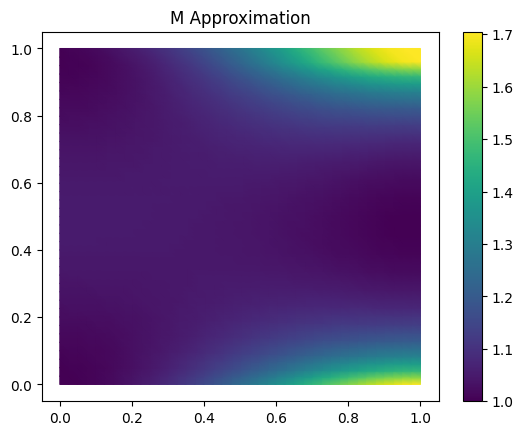

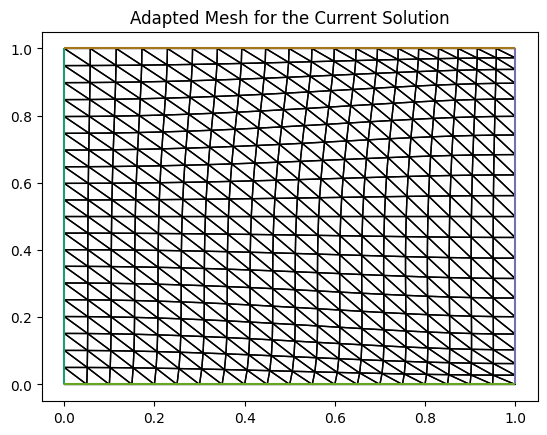



The Determinant of the gradient of the new mesh is :  0.9999999999999989



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.         1.00226204 1.00229499 1.00395615 1.0092813  1.00766456
 1.0090682  1.00894779 1.0212914  1.0147142  1.01771353 1.01276906
 1.01567947 1.03887844 1.02238724 1.03008551 1.0191379  1.01851047
 1.0230842  1.06279342 1.02992391 1.04644526 1.02807284 1.02316922
 1.02510002 1.03038797 1.0939497  1.03673502 1.06710691 1.03959903
 1.02959628 1.02838068 1.03171704 1.03700195 1.13336534 1.04236147
 1.09241572 1.0537437  1.03771284 1.03284101 1.03385803 1.03776521
 1.04247377 1.18207782 1.04645919 1.12271589 1.07052901 1.04742182
 1.03836836 1.03672763 1.03898064 1.04280248 1.04646767 1.24102933
 1.04879532 1.15830479 1.08996074 1.0586078  1.0448263  1.04021593
 1.04057948 1.04331419 1.04650888 1.04875781 1.31092536 1.04924876
 1.19937049 1.11201099 1.07113504 1.05205758 1.04419023 1.04247089
 1.04

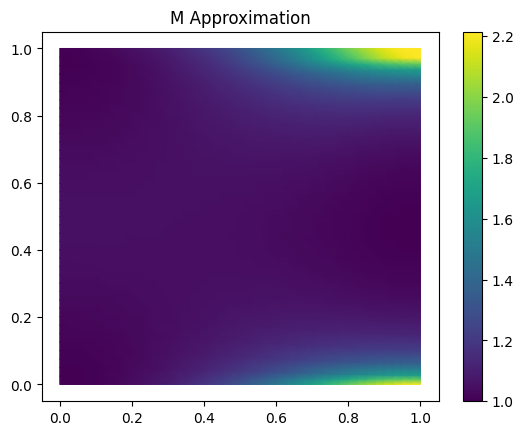

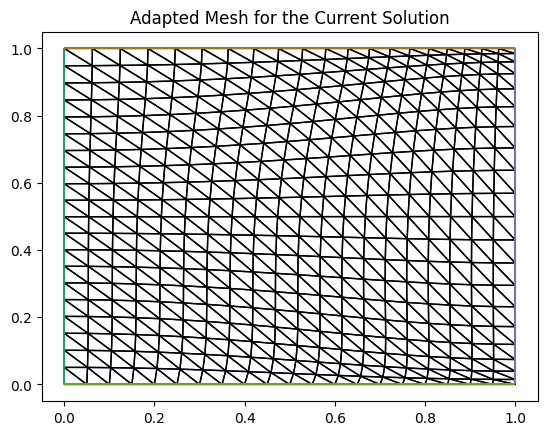



The Determinant of the gradient of the new mesh is :  0.9999999999999989



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.         1.00221742 1.00228457 1.0038974  1.00932431 1.0074234
 1.00899186 1.00873005 1.02173405 1.01415465 1.01772864 1.01260115
 1.01518277 1.04060802 1.02146059 1.03050274 1.01908962 1.01814527
 1.0222477  1.06760032 1.02863679 1.04788531 1.02828524 1.02301452
 1.02445016 1.02920308 1.1050296  1.03511875 1.07063651 1.0403114
 1.02974481 1.02800771 1.03073925 1.03548759 1.15597921 1.04044715
 1.09971807 1.05532085 1.03827132 1.03282273 1.0331793  1.03645129
 1.0406547  1.22434843 1.04426545 1.1362978  1.07349134 1.04850826
 1.0387626  1.03641825 1.03795254 1.04116515 1.0443631  1.3147937
 1.04632998 1.18173224 1.09501985 1.06034708 1.04566222 1.04031608
 1.03990163 1.04193511 1.04457223 1.04638199 1.4324928  1.04652163
 1.23750432 1.12011232 1.07365485 1.05332673 1.04470216 1.04217975
 1.04289

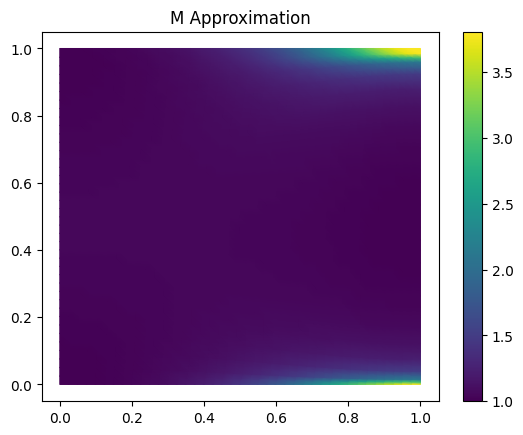

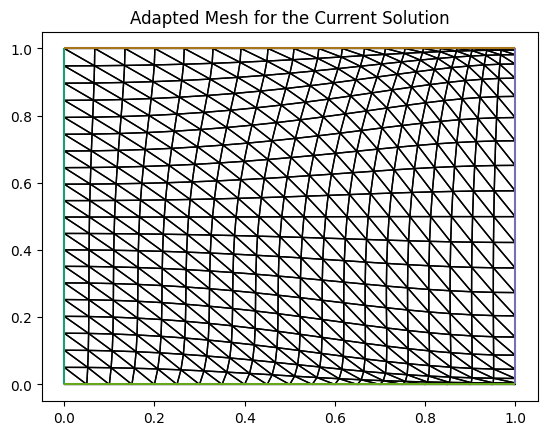



The Determinant of the gradient of the new mesh is :  0.9999999999999987



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[ 1.          1.00217312  1.00228609  1.00384606  1.00942329  1.00718507
  1.00894627  1.00851805  1.02235446  1.01360053  1.01782392  1.01245099
  1.01469196  1.04287535  1.02053681  1.03110629  1.01908776  1.01779081
  1.02141436  1.07399574  1.02734136  1.04975216  1.02860183  1.02288743
  1.02380575  1.02801151  1.1205426   1.03347443  1.07513967  1.04123267
  1.02995927  1.02765072  1.02975774  1.03394852  1.1900707   1.03847941
  1.10919826  1.05728218  1.03896334  1.03284615  1.03250525  1.03511766
  1.03878695  1.29411055  1.04199213  1.15459987  1.07711573  1.0498265
  1.03924424  1.0361317   1.03691377  1.03948663  1.04218478  1.44966374
  1.04376406  1.21502015  1.10117469  1.06243704  1.04665024  1.04046974
  1.03922855  1.04052651  1.04257226  1.04391232  1.68067015  1.04368453
  1.295

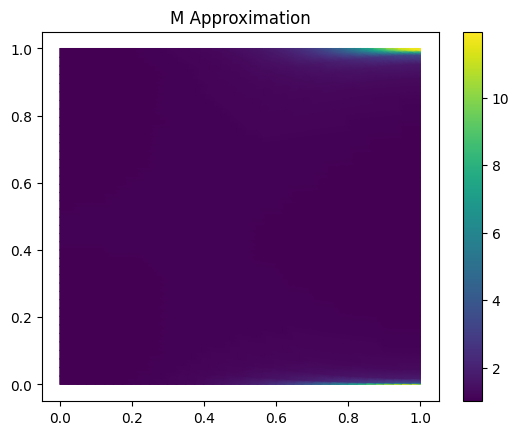

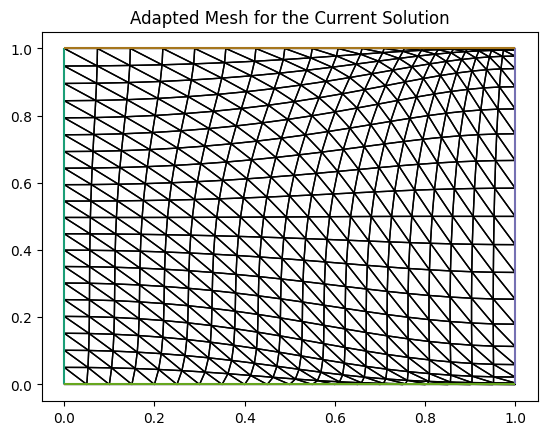



The Determinant of the gradient of the new mesh is :  0.9999999999999987



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[  1.           1.00212925   1.00229664   1.00379995   1.00956776
   1.00695037   1.00892216   1.00831077   1.02313959   1.01305413
   1.01797798   1.01231185   1.01420748   1.04572474   1.0196203
   1.03185924   1.01911482   1.01744228   1.02058638   1.08239033
   1.02604444   1.05199976   1.02898751   1.0227736    1.02316342
   1.02681744   1.14251887   1.03181133   1.08060639   1.04229879
   1.03021002   1.02729712   1.0287707    1.03239117   1.24364666
   1.03647019   1.1210638    1.05950937   1.03973461   1.03288519
   1.03182497   1.03376476   1.03687969   1.41872281   1.0396546
   1.17868656   1.0811704    1.0512783    1.03976734   1.03584498
   1.03585623   1.03777067   1.03994552   1.7291605    1.04111788
   1.26216864   1.10796527   1.06469326   1.0477127    1.04063811
   1.03854178   1.0

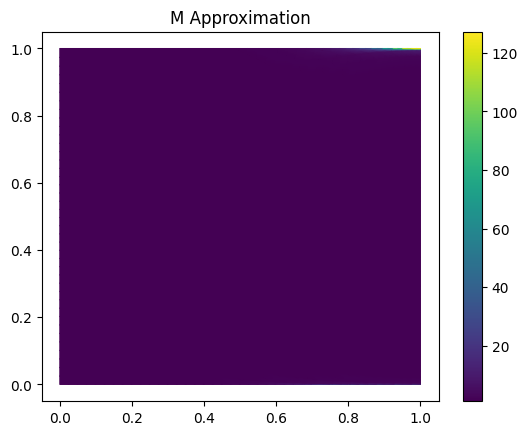

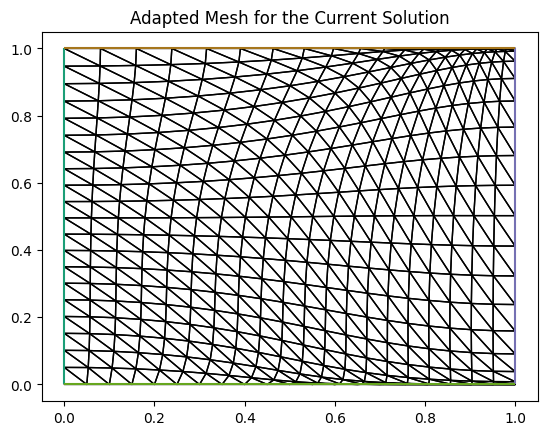



The Determinant of the gradient of the new mesh is :  0.9999999999999987



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.00000000e+00 1.00208601e+00 1.00231179e+00 1.00375606e+00
 1.00973987e+00 1.00672063e+00 1.00890602e+00 1.00810697e+00
 1.02405573e+00 1.01251921e+00 1.01815646e+00 1.01217423e+00
 1.01373053e+00 1.04916842e+00 1.01871888e+00 1.03269077e+00
 1.01914448e+00 1.01709336e+00 1.01976851e+00 1.09328698e+00
 1.02475957e+00 1.05449885e+00 1.02938454e+00 1.02265213e+00
 1.02252024e+00 1.02563082e+00 1.17425201e+00 1.03015046e+00
 1.08682848e+00 1.04339108e+00 1.03045034e+00 1.02693038e+00
 1.02778004e+00 1.03083262e+00 1.33301872e+00 1.03444983e+00
 1.13509434e+00 1.06175235e+00 1.04049226e+00 1.03290141e+00
 1.03112749e+00 1.03240171e+00 1.03495936e+00 1.66849881e+00
 1.03729460e+00 1.20908461e+00 1.08510483e+00 1.05268247e+00
 1.04025842e+00 1.03552857e+00 1.03477734e+00 1.03603639e+00
 1.03768336e+00 

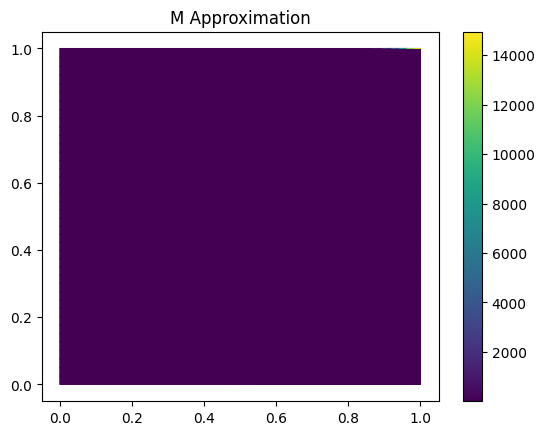

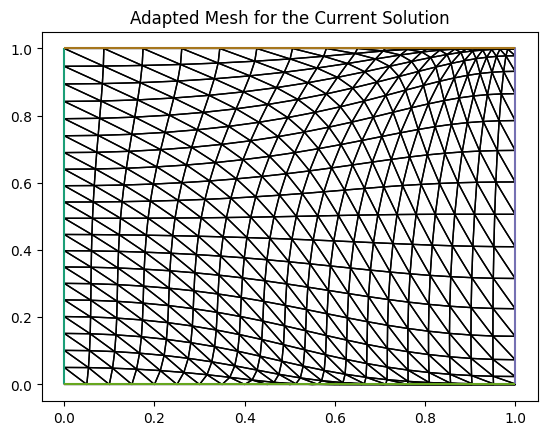



The Determinant of the gradient of the new mesh is :  0.9999999999999987



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.00000000e+00 1.00204366e+00 1.00232834e+00 1.00371251e+00
 1.00992632e+00 1.00649729e+00 1.00888861e+00 1.00790644e+00
 1.02507897e+00 1.01199994e+00 1.01833377e+00 1.01203233e+00
 1.01326350e+00 1.05325535e+00 1.01784143e+00 1.03354057e+00
 1.01915823e+00 1.01674120e+00 1.01896731e+00 1.10751549e+00
 1.02350274e+00 1.05711069e+00 1.02974660e+00 1.02250883e+00
 1.02187701e+00 1.02446465e+00 1.22196687e+00 1.02851750e+00
 1.09347288e+00 1.04439648e+00 1.03064335e+00 1.02654047e+00
 1.02679243e+00 1.02929508e+00 1.49705892e+00 1.03245626e+00
 1.15059282e+00 1.06371839e+00 1.04115260e+00 1.03286581e+00
 1.03040913e+00 1.03104414e+00 1.03306018e+00 2.26950570e+00
 1.03496440e+00 1.24620888e+00 1.08815452e+00 1.05385270e+00
 1.04065567e+00 1.03516329e+00 1.03368305e+00 1.03431150e+00
 1.03544683e+00 

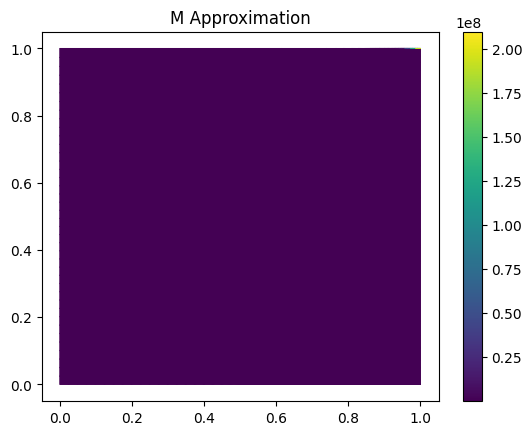

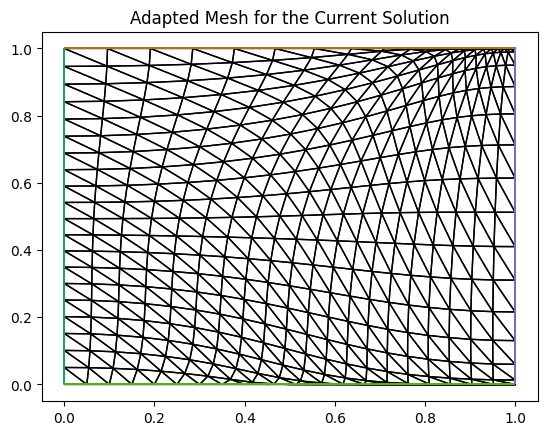



The Determinant of the gradient of the new mesh is :  0.9999999999999991



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.00000000e+00 1.00200207e+00 1.00234441e+00 1.00366779e+00
 1.01011913e+00 1.00627964e+00 1.00886330e+00 1.00770722e+00
 1.02619850e+00 1.01149443e+00 1.01849022e+00 1.01187965e+00
 1.01280297e+00 1.05808986e+00 1.01698466e+00 1.03435436e+00
 1.01913843e+00 1.01637751e+00 1.01817745e+00 1.12647695e+00
 1.02226965e+00 1.05967029e+00 1.03002856e+00 1.02232450e+00
 1.02122297e+00 1.02331206e+00 1.29844214e+00 1.02690803e+00
 1.09997355e+00 1.04519198e+00 1.03074678e+00 1.02610597e+00
 1.02579521e+00 1.02777126e+00 1.84547508e+00 1.03048617e+00
 1.16614793e+00 1.06504060e+00 1.04162257e+00 1.03273826e+00
 1.02964746e+00 1.02967900e+00 1.03117588e+00 4.25809558e+00
 1.03266314e+00 1.29488414e+00 1.08934124e+00 1.05457985e+00
 1.04088711e+00 1.03471254e+00 1.03255194e+00 1.03258453e+00
 1.03323223e+00 

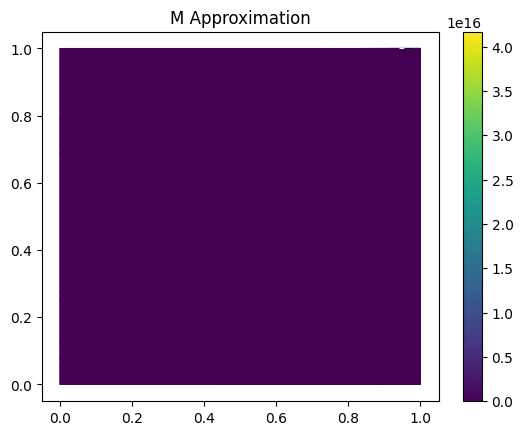

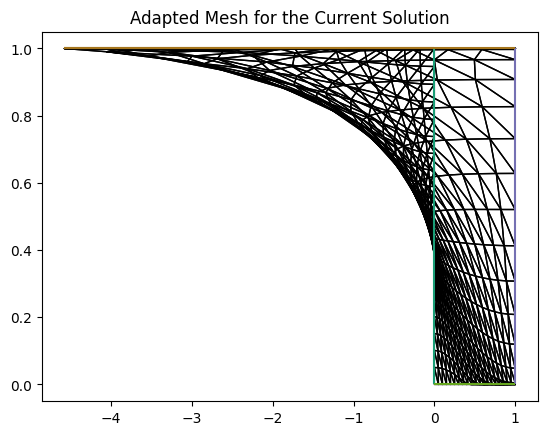



The Determinant of the gradient of the new mesh is :  nan



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Values of M at vertices:
[1.00000000e+00 1.00251569e+00 1.00235926e+00 1.00478716e+00
 1.01031506e+00 1.01038809e+00 1.01206528e+00 1.01299774e+00
 1.02741675e+00 1.02663508e+00 1.02613710e+00 1.02105995e+00
 1.02952594e+00 1.06385066e+00 1.06025775e+00 1.05069967e+00
 1.03550946e+00 1.03866402e+00 1.06249670e+00 1.15260124e+00
 1.13905134e+00 1.09224170e+00 1.05779839e+00 1.05406709e+00
 1.07176416e+00 1.13631479e+00 1.43297351e+00 1.37973629e+00
 1.15883982e+00 1.08921735e+00 1.07557034e+00 1.08691597e+00
 1.14055824e+00 1.34727677e+00 2.78625849e+00 2.81149516e+00
 1.25271729e+00 1.12857444e+00 1.10226433e+00 1.10631781e+00
 1.14966962e+00 1.31750713e+00 2.41182579e+00 1.84137763e+01
 4.14258267e+00 1.44079818e+00 1.16952660e+00 1.13152936e+00
 1.12782888e+00 1.16100954e+00 1.29296497e+00 2.02928033e+00
 6.27400733e+00 8.85206091e+02

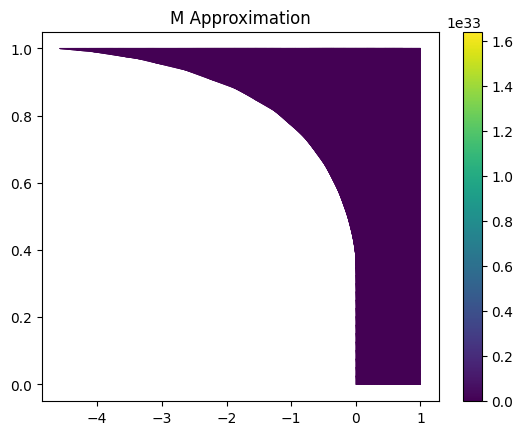

ConvergenceError: ignored

In [ ]:
# now mesh solve

new_mesh = Mesh_Iter(u_sol, mesh0, V, 10)